# This notebook explores the data and does feature selection (with VIF and Lasso)


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns


def load_and_preprocess_data(file_path):
    """_summary_
    s

    Args:
        file_path (_type_): _description_

    Returns:
        _type_: _description_
    """
    # drop unnecessary columns
    data = pd.read_csv(file_path)
    data = data.dropna()  
    data.drop(columns=['Unnamed: 0'], inplace=True)

    # convert timestamp to datetime
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    return data


#  the dataset
file_path = 'MetroPT3(AirCompressor).csv'
data = load_and_preprocess_data(file_path)



In [3]:
data.head()

timestamp    TP2    TP3     H1  DV_pressure  Reservoirs  \
0 2020-02-01 00:00:00 -0.012  9.358  9.340       -0.024       9.358   
1 2020-02-01 00:00:10 -0.014  9.348  9.332       -0.022       9.348   
2 2020-02-01 00:00:19 -0.012  9.338  9.322       -0.022       9.338   
3 2020-02-01 00:00:29 -0.012  9.328  9.312       -0.022       9.328   
4 2020-02-01 00:00:39 -0.012  9.318  9.302       -0.022       9.318   

   Oil_temperature  Motor_current  COMP  DV_eletric  Towers  MPG  LPS  \
0           53.600         0.0400   1.0         0.0     1.0  1.0  0.0   
1           53.675         0.0400   1.0         0.0     1.0  1.0  0.0   
2           53.600         0.0425   1.0         0.0     1.0  1.0  0.0   
3           53.425         0.0400   1.0         0.0     1.0  1.0  0.0   
4           53.475         0.0400   1.0         0.0     1.0  1.0  0.0   

   Pressure_switch  Oil_level  Caudal_impulses  
0              1.0        1.0              1.0  
1              1.0        1.0              1.0  
2              1.0        1.0              1.0  
3              1.0        1.0              1.0  
4              1.0        1.0              1.0

### Based on description provided by the data, I manually labelled the anomalies based on the timestamp column


In [54]:
import pandas as pd

def label_anomalies(data: pd.DataFrame, anomaly_periods: list, timestamp_col: str = 'timestamp', label_col: str = 'class') -> pd.DataFrame:
    """
    Label anomalies in a DataFrame based on given periods.

    Parameters:
    - data (pd.DataFrame): The input DataFrame containing timestamps.
    - anomaly_periods (list): List of tuples with start and end times for anomaly periods.
    - timestamp_col (str): The name of the column containing timestamps. Default is 'timestamp'.
    - label_col (str): The name of the column to label anomalies. Default is 'class'.

    Returns:
    - pd.DataFrame: DataFrame with anomalies labeled.
    """
    
    # Initialize the label column with 0
    data[label_col] = 0
    # Label the anomalies
    for start, end in anomaly_periods:
        start_time = pd.to_datetime(start)
        end_time = pd.to_datetime(end)
        data.loc[(data[timestamp_col] >= start_time) & (data[timestamp_col] <= end_time), label_col] = 1

    return data


# Define anomaly periods
anomaly_periods = [
    ('2020-04-18 00:00:00', '2020-04-18 23:59:00'),
    ('2020-05-29 23:30:00', '2020-05-30 06:00:00'),
    ('2020-06-05 10:00:00', '2020-06-07 14:30:00'),
    ('2020-07-15 14:30:00', '2020-07-15 19:00:00')
]




In [55]:
# Label anomalies in the data
data = label_anomalies(data, anomaly_periods)
data.head()

timestamp    TP2    TP3     H1  DV_pressure  Reservoirs  \
0 2020-02-01 00:00:00 -0.012  9.358  9.340       -0.024       9.358   
1 2020-02-01 00:00:10 -0.014  9.348  9.332       -0.022       9.348   
2 2020-02-01 00:00:19 -0.012  9.338  9.322       -0.022       9.338   
3 2020-02-01 00:00:29 -0.012  9.328  9.312       -0.022       9.328   
4 2020-02-01 00:00:39 -0.012  9.318  9.302       -0.022       9.318   

   Oil_temperature  Motor_current  COMP  DV_eletric  Towers  MPG  LPS  \
0           53.600         0.0400   1.0         0.0     1.0  1.0  0.0   
1           53.675         0.0400   1.0         0.0     1.0  1.0  0.0   
2           53.600         0.0425   1.0         0.0     1.0  1.0  0.0   
3           53.425         0.0400   1.0         0.0     1.0  1.0  0.0   
4           53.475         0.0400   1.0         0.0     1.0  1.0  0.0   

   Pressure_switch  Oil_level  Caudal_impulses  class  
0              1.0        1.0              1.0      0  
1              1.0        1.0              1.0      0  
2              1.0        1.0              1.0      0  
3              1.0        1.0              1.0      0  
4              1.0        1.0              1.0      0

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516948 entries, 0 to 1516947
Data columns (total 17 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   timestamp        1516948 non-null  datetime64[ns]
 1   TP2              1516948 non-null  float64       
 2   TP3              1516948 non-null  float64       
 3   H1               1516948 non-null  float64       
 4   DV_pressure      1516948 non-null  float64       
 5   Reservoirs       1516948 non-null  float64       
 6   Oil_temperature  1516948 non-null  float64       
 7   Motor_current    1516948 non-null  float64       
 8   COMP             1516948 non-null  float64       
 9   DV_eletric       1516948 non-null  float64       
 10  Towers           1516948 non-null  float64       
 11  MPG              1516948 non-null  float64       
 12  LPS              1516948 non-null  float64       
 13  Pressure_switch  1516948 non-null  float64       
 14  Oi

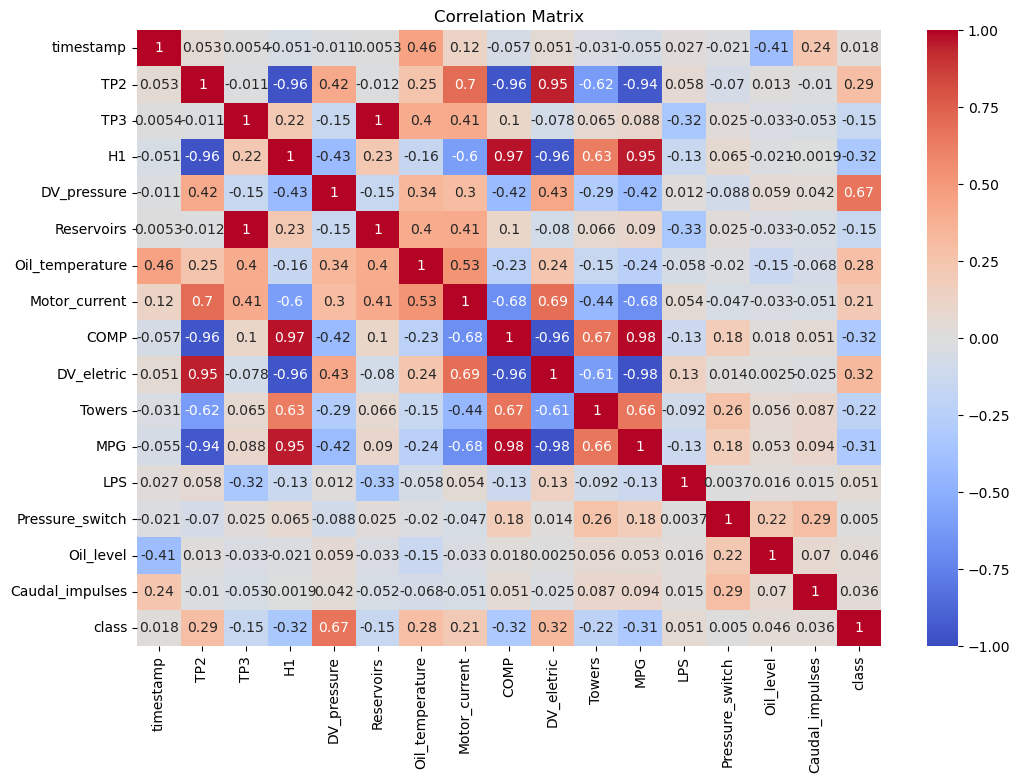

In [7]:
# Correlation matrix
corr_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

#### Insights from the Correlation Matrix

The correlation matrix reveals a strong positive correlation with pressure, indicating that as pressure increases, certain variables tend to rise as well. Additionally, there is a positive relationship with DV_electric and TP2.

 On the other hand, a negative correlation is observed between the class label and COMP, implying an inverse relationship where increases in COMP might be linked to a decrease in the likelihood of anomaly.


### Computing correlation  and  VIF to check for multicollinearity below.


#### Below shows various features with high multicoleniarity in it, usually above 10 is considered very high but we can start removing the much higher ones before the ons under 100.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def calculate_vif(X):
    # Adding a constant term to the features for the intercept
    X_const = add_constant(X)
    # Calculating VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
    return vif_data


X = data.drop(columns=['timestamp', 'class'])  # remving timestamp and target from the mix
vif = calculate_vif(X)
vif['VIF'] = vif['VIF'].apply(lambda x: '{:.2f}'.format(x))
print(vif)

            Feature        VIF
0             const     575.88
1               TP2      33.56
2               TP3  101397.27
3                H1      97.63
4       DV_pressure       1.68
5        Reservoirs  101309.58
6   Oil_temperature       1.81
7     Motor_current       4.17
8              COMP      93.16
9        DV_eletric     136.21
10           Towers       1.90
11              MPG     184.00
12              LPS       1.35
13  Pressure_switch       5.03
14        Oil_level       1.17
15  Caudal_impulses       1.32


#### To reduce multicollinearity in the dataset, the first step is to identify features with a high Variance Inflation Factor (VIF) and decide whether they should be removed or transformed. High VIF values (generally above 10) indicate significant multicollinearity, which can distort model estimates and reduce the predictive power. SO we remove TP3, Reservoirs, and MPG.


####  We use principal component analysis for dimensionality reduction, which transforms a large set of features into a smaller set while retaining most of the original variance in the data. It does this by identifying directions which are the principal components that explain the most variance. The first principal component explains the most variance, the second explains the next most, and so on. By projecting the data onto these principal components, PCA reduces the dimensionality of the dataset without losing much of the information.

In [10]:
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Remove ones with high VIF
X_reduced = X.drop(columns=['TP3', 'Reservoirs', 'MPG'])

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_reduced)
X_pca_df = pd.DataFrame(X_pca)

# Compute VIF for the new dataset
vif_data = pd.DataFrame()
vif_data["Feature"] = X_reduced.columns
vif_data["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]
print(vif_data)


            Feature         VIF
0               TP2   19.347490
1                H1  210.904421
2       DV_pressure    1.463877
3   Oil_temperature  118.284425
4     Motor_current    5.110650
5              COMP  324.162099
6        DV_eletric   30.937725
7            Towers   23.527964
8               LPS    1.097595
9   Pressure_switch  280.110323
10        Oil_level   11.461534
11  Caudal_impulses   18.084285


### Based on the new VIF values after PCA, the features with high VIF values still indicate some multicollinearity. So, we repeart this process.

In [18]:
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Remove the more features based on VIF
X_reduced = X.drop(columns=['TP3', 'Reservoirs', 'MPG','COMP', 'Pressure_switch', 'H1'])


scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_reduced)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_standardized)
X_pca_df = pd.DataFrame(X_pca)


# Compute VIF for the new dataset
vif_data = pd.DataFrame()
vif_data["Feature"] = X_reduced.columns
vif_data["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]
vif_data['VIF'] = vif_data['VIF'].apply(lambda x: '{:.2f}'.format(x))
print(vif_data)


           Feature    VIF
0              TP2  12.92
1      DV_pressure   1.28
2  Oil_temperature  33.72
3    Motor_current   4.18
4       DV_eletric  12.81
5           Towers  19.28
6              LPS   1.08
7        Oil_level   9.74
8  Caudal_impulses  14.97


#### Lasso regression is a regularization technique that applies a penalty to prevent overfitting and enhance the accuracy of statistical models. Lasso regression—also known as L1 regularization—is a form of regularization for linear regression models. Regularization is a statistical method to reduce errors caused by overfitting on training data. This also confirms th results from our PCA-ViF analysis above.


In [19]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

y=data['class']
# Standardize the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_reduced)

# Apply Lasso Regression
lasso = LassoCV(cv=5, random_state=0).fit(X_standardized, y)  

# Get the selected features
selected_features = X_reduced.columns[lasso.coef_ != 0]
print("Selected features:", selected_features)


Selected features: Index(['TP2', 'DV_pressure', 'Oil_temperature', 'Motor_current', 'DV_eletric',
       'Towers', 'LPS', 'Oil_level', 'Caudal_impulses'],
      dtype='object')


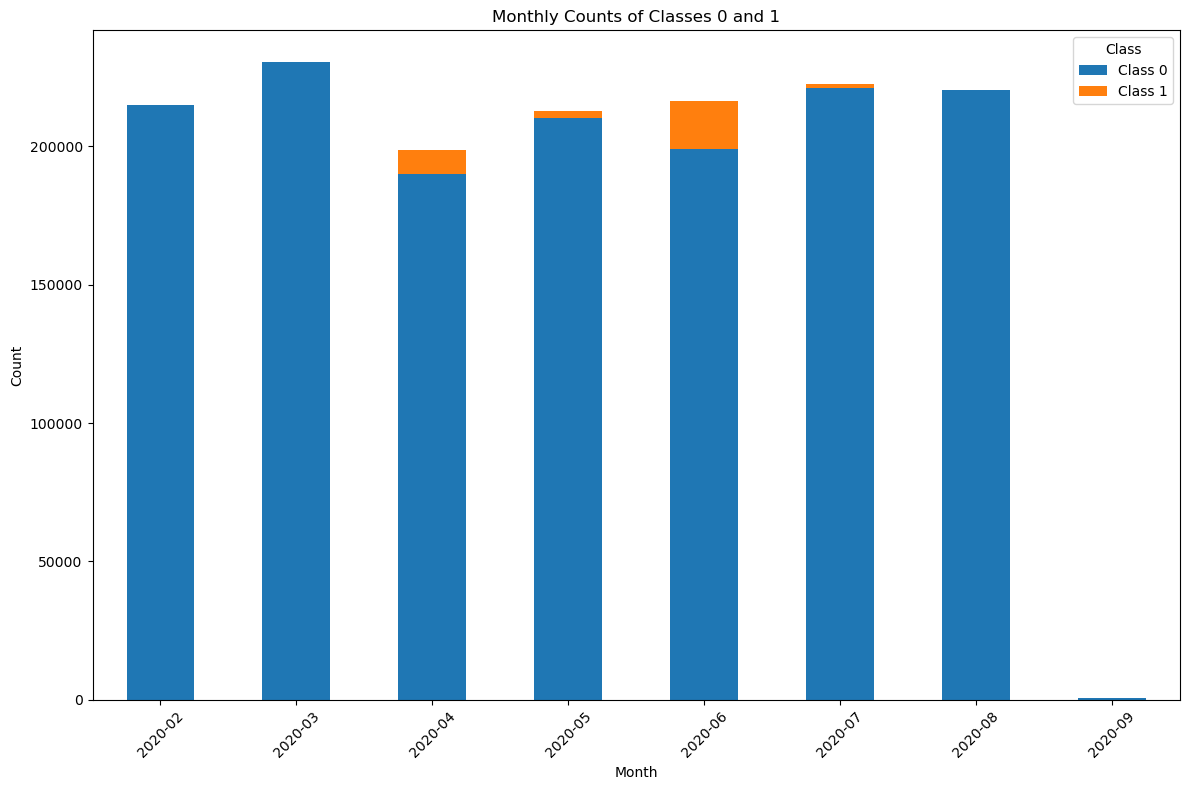

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


data['month'] = data['timestamp'].dt.to_period('M')
monthly_class_counts = data.groupby(['month', 'class']).size().unstack(fill_value=0)

# Plotting
monthly_class_counts.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly Counts of Classes 0 and 1')
plt.legend(title='Class', labels=['Class 0', 'Class 1'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#extracting the months with both the classes
months_with_both_classes = monthly_class_counts[(monthly_class_counts[0] > 0) & (monthly_class_counts[1] > 0)].index
filtered_data = data[data['month'].isin(months_with_both_classes)]

# Saving
filtered_data.to_csv('Metro-Both-Classes.csv', index=False)



#### Based on the analysis using Principal Component Analysis (PCA), Variance Inflation Factor (VIF), and Lasso regression, we have identified a refined set of features for classification. Specifically, the following features have been selected for their relevance and reduced multicollinearity: TP2, DV_pressure, Oil_temperature, Motor_current, DV_eletric, Towers, LPS,Oil_level, Caudal_impulses. In addition to feature selection, we have also filtered out data from months where only one of the two classes (0 or 1) is present. This ensures that the classification task has data from months where both classes are represented, which is crucial for building a robust and balanced model. The refined dataset now includes:


#### Features: ['TP2', 'DV_pressure', 'Oil_temperature', 'Motor_current', 'DV_eletric', 'Towers', 'LPS', 'Oil_level', 'Caudal_impulses']
#### Filtered Data: Only includes months with occurrences of both classes (0 and 1).












## Below are some visualizations to look at hourly trends for our final set of features.

C:\Users\nandi\AppData\Local\Temp\ipykernel_12252\3633839773.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = filtered_data[feature].resample('H').mean()
C:\Users\nandi\AppData\Local\Temp\ipykernel_12252\3633839773.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_hours = filtered_data['class'].resample('H').max() == 1


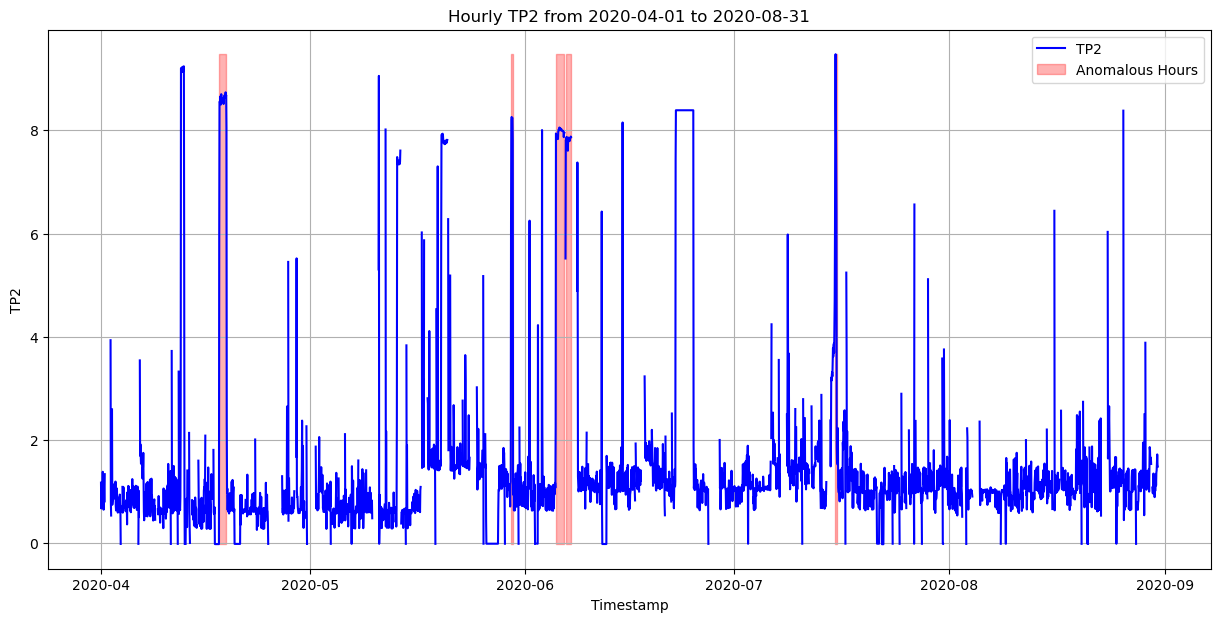

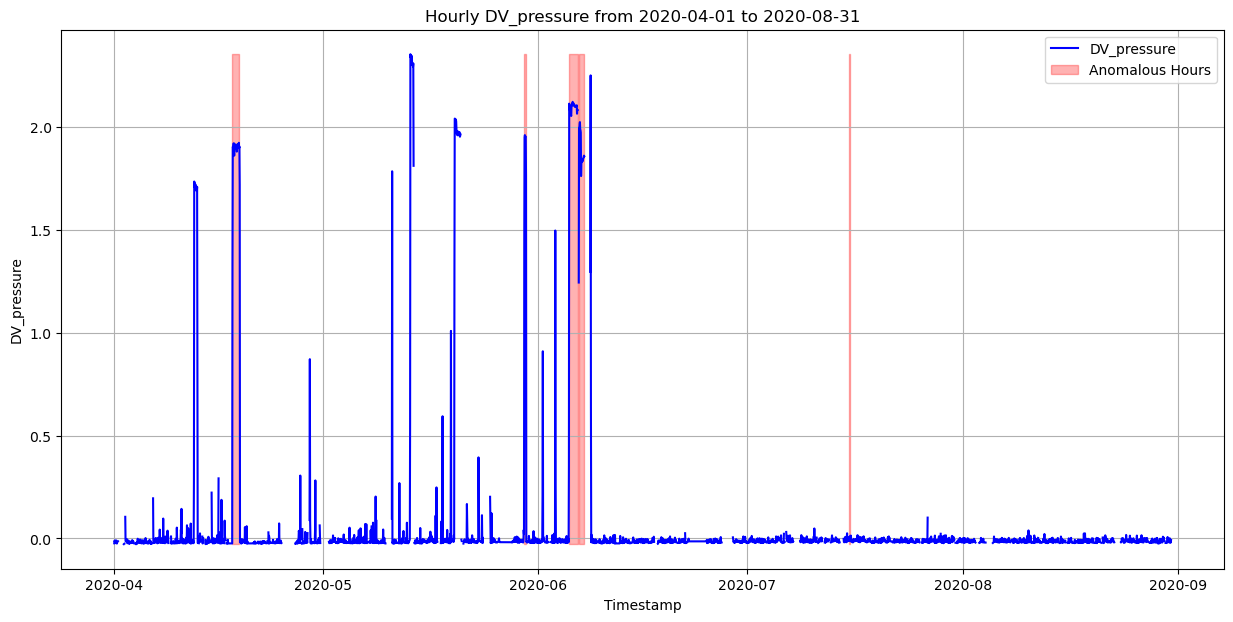

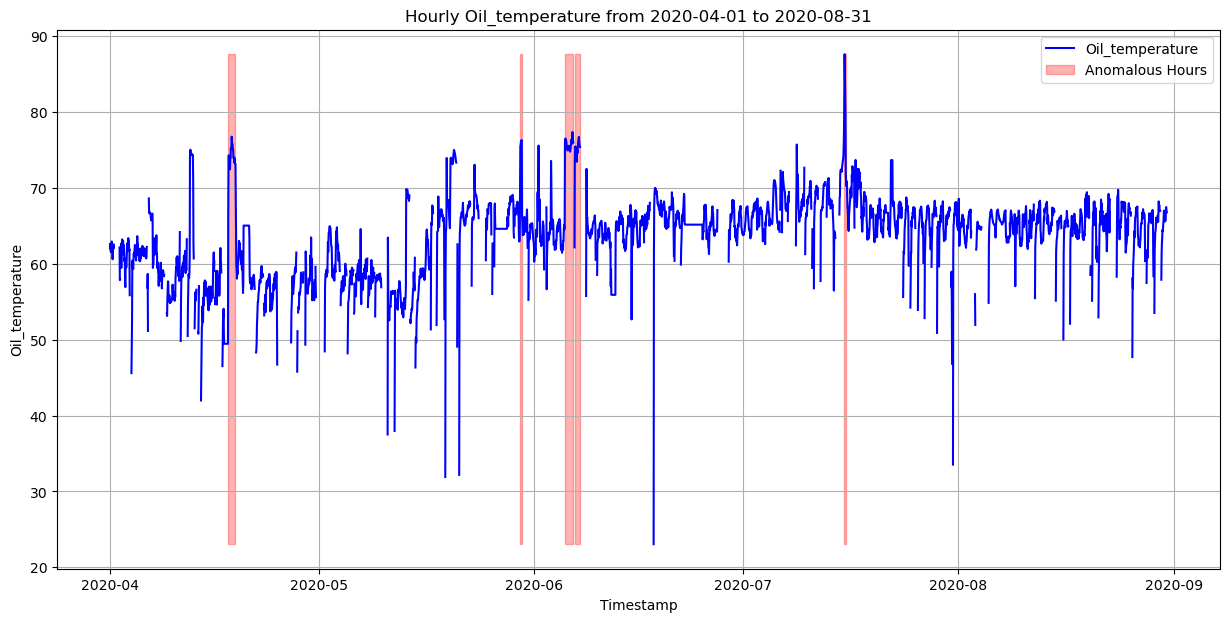

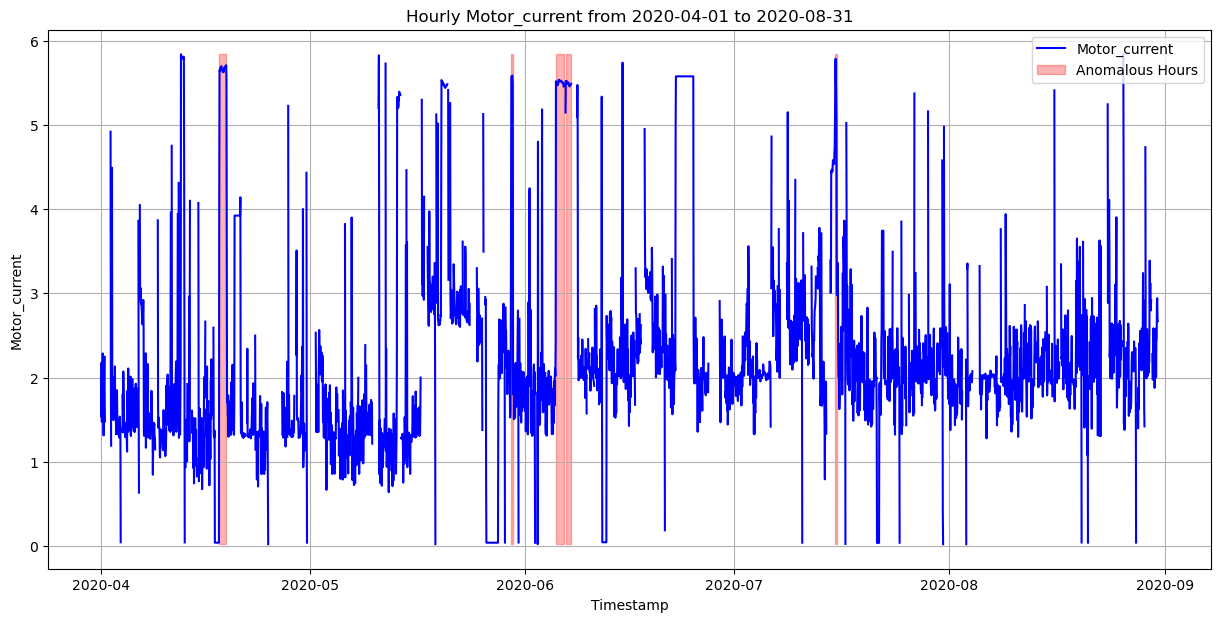

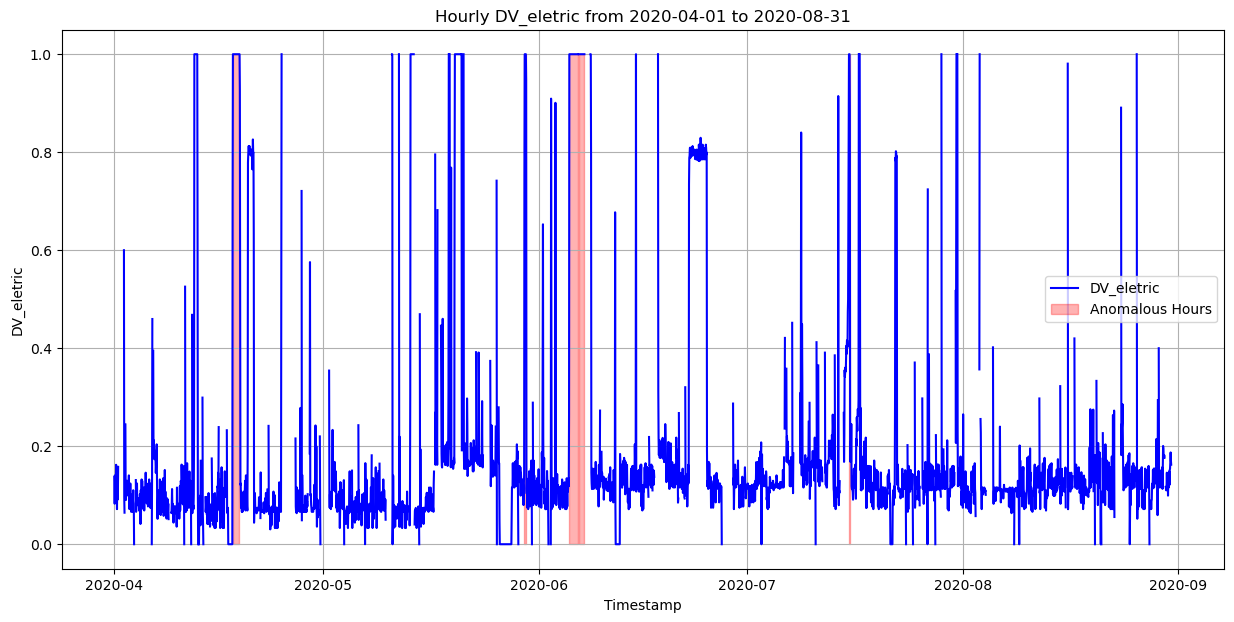

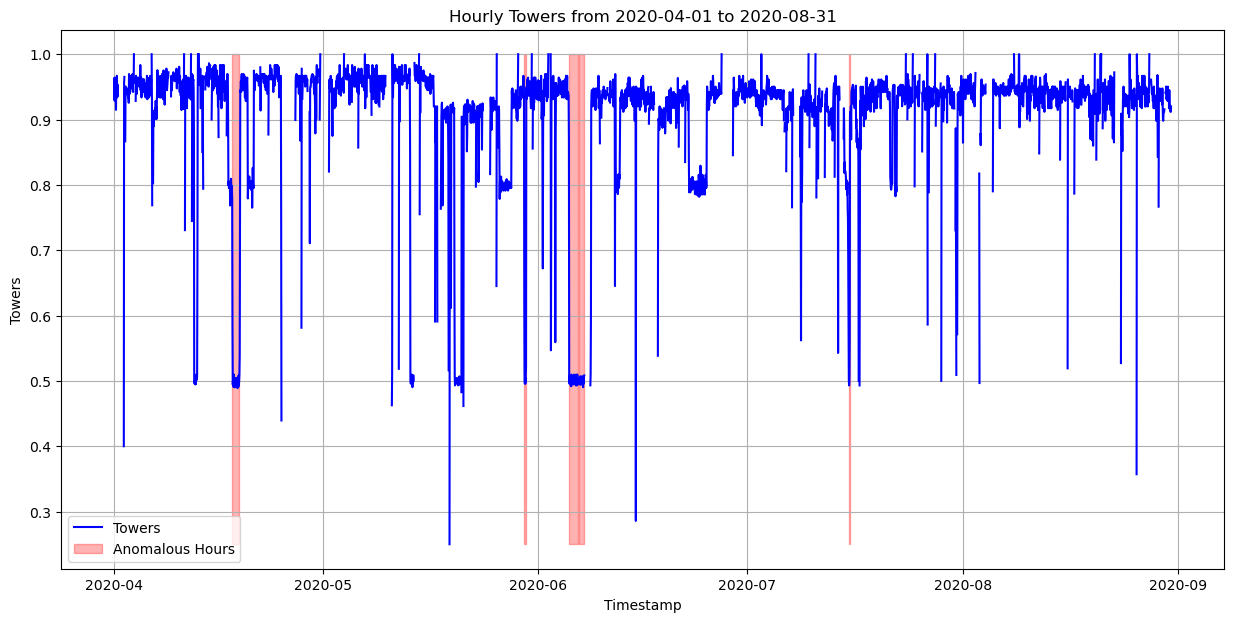

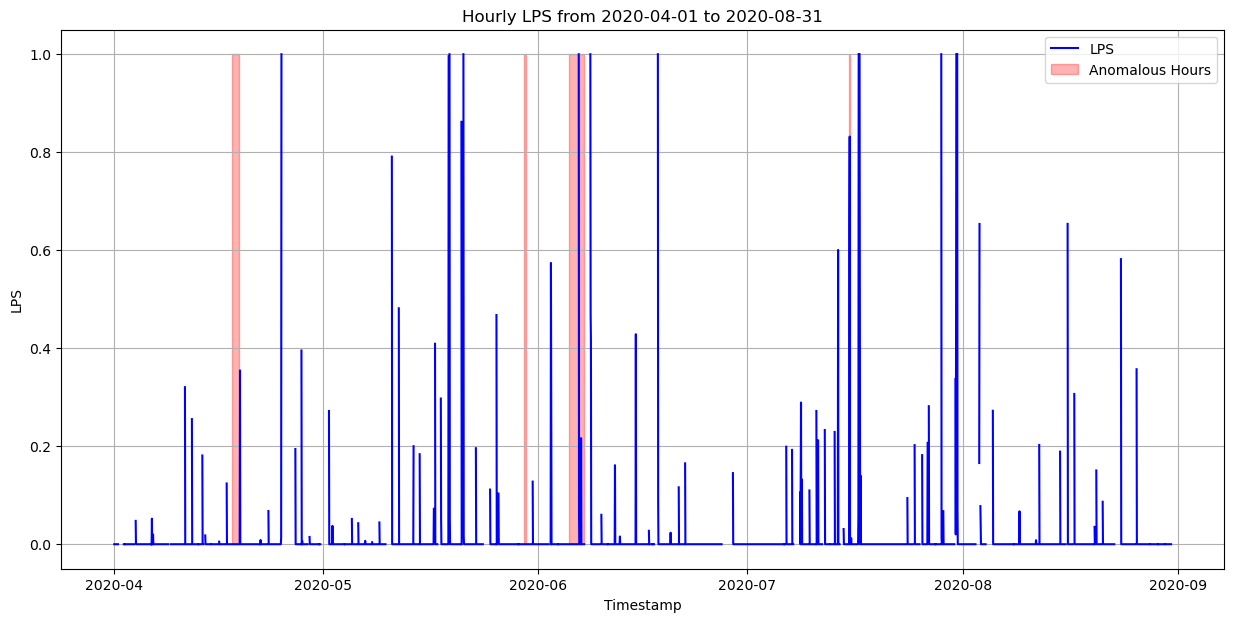

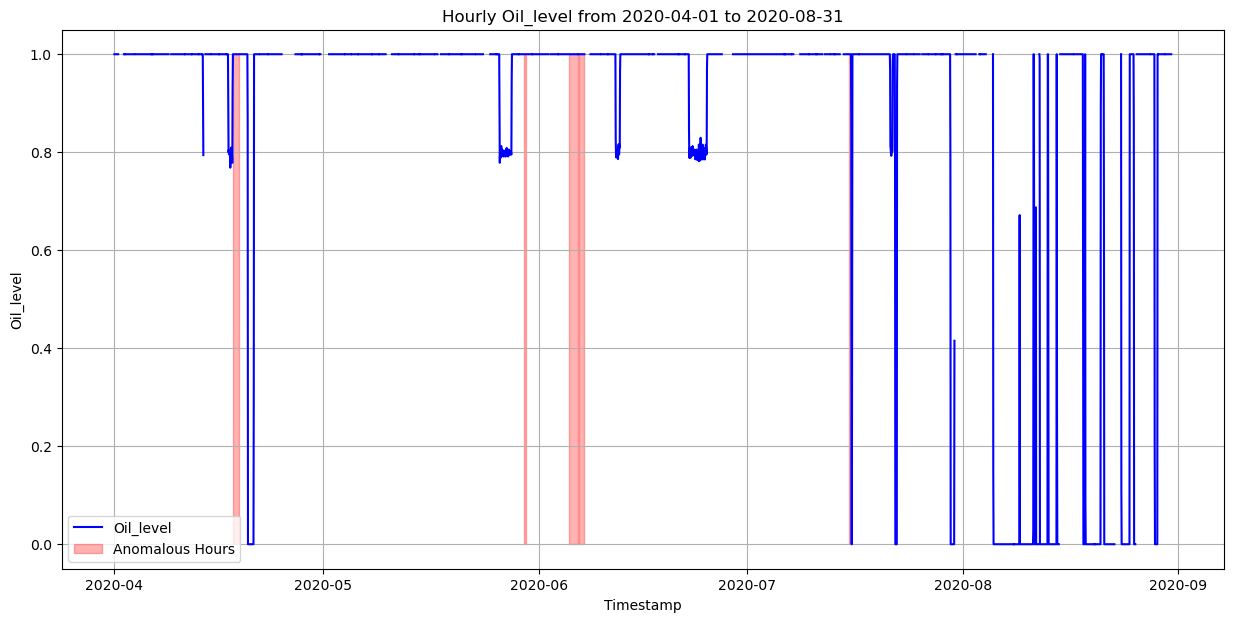

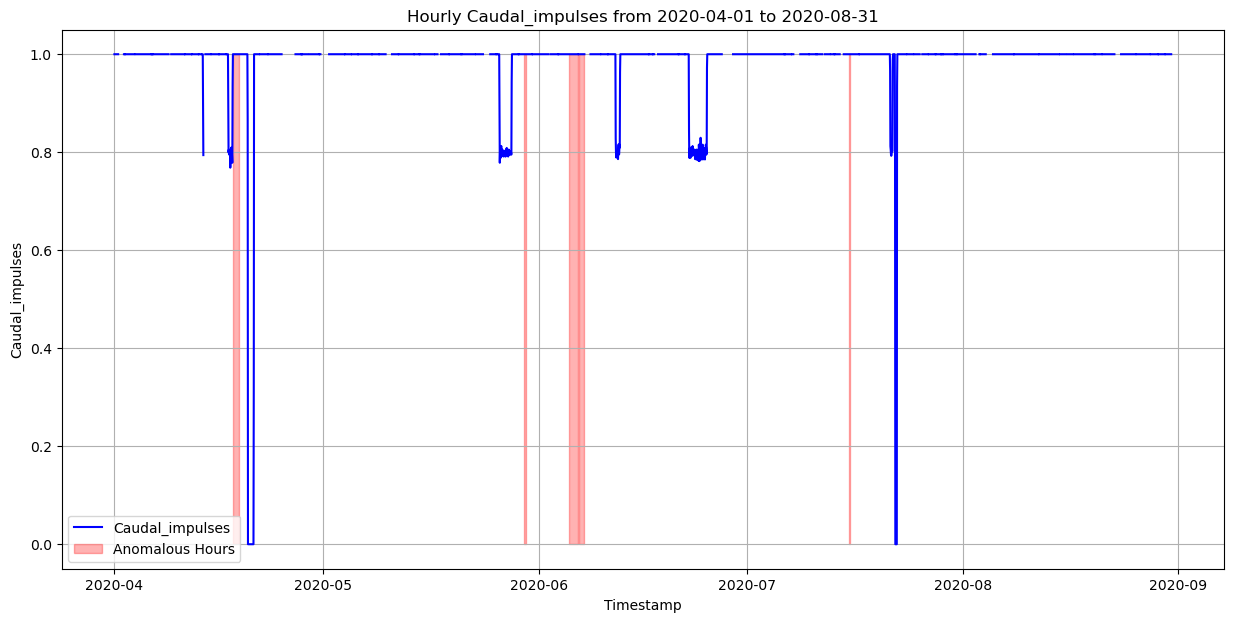

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_hourly_data_with_anomalies(data, features, start_date, end_date):
    """
    Plot hourly data for multiple features over a given time range,
    highlighting hours where there is at least one anomaly.

    Parameters:
    data (pd.DataFrame): The dataset containing time series data.
    features (list of str): List of column names of the variables to plot.
    start_date (str): The start date for filtering data, format 'YYYY-MM-DD'.
    end_date (str): The end date for filtering data, format 'YYYY-MM-DD'.
    """
    # Ensure timestamp is a datetime column
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    
    # Filter data for the specific date range
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    filtered_data = data[(data['timestamp'] >= start_date) & (data['timestamp'] < end_date)]
    
    # Set timestamp as index
    filtered_data.set_index('timestamp', inplace=True)
    
    for feature in features:
        # Resample data by hour and calculate mean
        hourly_data = filtered_data[feature].resample('H').mean()
        
        # Create a mask for anomalous hours
        anomaly_hours = filtered_data['class'].resample('H').max() == 1
        
        # Plot
        plt.figure(figsize=(15, 7))
        plt.plot(hourly_data.index, hourly_data, label=feature, color='blue')
        
        # Highlight anomalous hours
        plt.fill_between(hourly_data.index, hourly_data.min(), hourly_data.max(), where=anomaly_hours, color='red', alpha=0.3, label='Anomalous Hours')
        
        plt.xlabel('Timestamp')
        plt.ylabel(feature)
        plt.title(f'Hourly {feature} from {start_date.date()} to {end_date.date()}')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage
features = ['TP2', 'DV_pressure', 'Oil_temperature', 'Motor_current', 'DV_eletric', 'Towers', 'LPS', 'Oil_level', 'Caudal_impulses']
plot_hourly_data_with_anomalies(data, features, '2020-04-01', '2020-08-31')


In [57]:
import pandas as pd

def mark_anomalous_hours(data):
    """
    Mark each hour as anomalous if there is at least one anomaly within that hour.
    The function creates a new column 'anomalous_hour' which is 1 if the hour contains an anomaly, otherwise 0.

    Parameters:
    data (pd.DataFrame): The dataset containing time series data with 'timestamp' and 'class' columns.

    Returns:
    pd.DataFrame: A DataFrame with an additional column 'anomalous_hour' indicating anomalous hours.
    """
    # Ensure timestamp is a datetime column
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    
    # Set timestamp as index
    data.set_index('timestamp', inplace=True)
    
    # Resample the data by hour
    hourly_data = data.resample('H').agg({'class': 'max'})  # Get the maximum value of 'class' per hour
    
    # Create a new column 'anomalous_hour' where 1 indicates at least one anomaly in that hour
    hourly_data['anomalous_hour'] = (hourly_data['class'] == 1).astype(int)
    
    # Merge the hourly data with the original data to show anomalous hours
    data = data.join(hourly_data['anomalous_hour'], how='left')
    
    # Fill NaN values in 'anomalous_hour' with 0 (no anomalies in hours without data)
    data['anomalous_hour'].fillna(0, inplace=True)
    
    return data

def show_anomalous_rows(data):
    """
    Display rows where 'anomalous_hour' is 1.

    Parameters:
    data (pd.DataFrame): The dataset with the 'anomalous_hour' column.

    Returns:
    pd.DataFrame: A DataFrame containing only the rows where 'anomalous_hour' is 1.
    """
    return data[data['anomalous_hour'] == 1]


# Mark anomalous hours
data_with_anomalies = mark_anomalous_hours(data)

# Show anomalous rows
anomalous_rows = show_anomalous_rows(data_with_anomalies)

# Display the anomalous rows
print(anomalous_rows)


                       TP2    TP3     H1  DV_pressure  Reservoirs  \
timestamp                                                           
2020-04-18 01:00:00  6.598  8.778 -0.008        1.328       8.778   
2020-04-18 11:00:00  9.040  8.858 -0.006        2.028       8.860   
2020-05-30 01:00:00  8.576  8.396 -0.008        2.056       8.398   
2020-06-05 12:00:00  8.198  8.122 -0.006        2.202       8.126   
2020-06-06 00:00:00  7.512  8.174 -0.008        1.944       8.176   
2020-06-06 06:00:00  8.380  8.166 -0.008        2.222       8.170   
2020-06-06 11:00:00  7.700  8.166 -0.006        1.996       8.166   
2020-06-06 20:00:00  7.600  7.378 -0.012        1.916       7.378   
2020-06-07 08:00:00  8.090  7.886 -0.010        1.920       7.886   
2020-06-07 14:00:00  8.230  8.004 -0.006        1.972       8.008   
2020-07-15 18:00:00  7.608  7.178 -0.002       -0.008       7.174   
2020-07-15 19:00:00 -0.006  8.724  8.710       -0.010       8.728   

                     Oil_temperat

C:\Users\nandi\AppData\Local\Temp\ipykernel_12252\944196110.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = data.resample('H').agg({'class': 'max'})  # Get the maximum value of 'class' per hour
C:\Users\nandi\AppData\Local\Temp\ipykernel_12252\944196110.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['anomalous_hour'].fillna(0, inplace=True)


In [78]:
import pandas as pd

def load_and_preprocess_data(file_path):
    """
    Load and preprocess the data for SVM. Aggregate the data hourly and
    mark hours as anomalous if there is at least one anomaly in that hour.

    Parameters:
    file_path (str): Path to the CSV file.

    Returns:
    pd.DataFrame: Preprocessed DataFrame with hourly aggregation and anomaly flags.
    """
    # Load data
    data = pd.read_csv(file_path)
    
    # Convert timestamp to datetime
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    
    # Set timestamp as index
    data.set_index('timestamp', inplace=True)
    
    # Aggregate data by hour
    hourly_data = data.resample('H').agg({
        'class': 'max',          # Anomaly indicator
        'TP2': 'mean',           # Example feature
        'DV_pressure': 'mean',   # Example feature
        'Oil_temperature': 'mean', # Example feature
        'Motor_current': 'mean', # Example feature
        'DV_eletric': 'mean',    # Example feature
        'Towers': 'mean',        # Example feature
        'LPS': 'mean',           # Example feature
        'Oil_level': 'mean',     # Example feature
        'Caudal_impulses': 'mean' # Example feature
    })
    
    # Create a new column 'anomalous_hour' where 1 indicates at least one anomaly in that hour
    hourly_data['anomalous_hour'] = (hourly_data['class'] == 1).astype(int)
    
    # Fill NaN values in 'anomalous_hour' with 0 (no anomalies in hours without data)
    hourly_data['anomalous_hour'].fillna(0, inplace=True)
    
    # Drop 'class' column if no longer needed
    hourly_data.drop(columns=['class'], inplace=True)
    
    return hourly_data

# Example usage
file_path = 'Metro-Both-Classes.csv'
data = load_and_preprocess_data(file_path)



                          TP2  DV_pressure  Oil_temperature  Motor_current  \
timestamp                                                                    
2020-04-01 00:00:00  1.173895    -0.023510        62.582094       1.992287   
2020-04-01 01:00:00  0.673019    -0.009967        61.950275       1.536522   
2020-04-01 02:00:00  1.146579    -0.014501        62.569835       2.176419   
2020-04-01 03:00:00  0.843620    -0.019030        61.533609       1.474056   
2020-04-01 04:00:00  1.183510    -0.019047        62.637328       2.164435   

                     DV_eletric    Towers  LPS  Oil_level  Caudal_impulses  \
timestamp                                                                    
2020-04-01 00:00:00    0.137741  0.931129  0.0        1.0              1.0   
2020-04-01 01:00:00    0.082645  0.964187  0.0        1.0              1.0   
2020-04-01 02:00:00    0.140496  0.928375  0.0        1.0              1.0   
2020-04-01 03:00:00    0.093664  0.958678  0.0        1.0      

C:\Users\nandi\AppData\Local\Temp\ipykernel_12252\1807491785.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = data.resample('H').agg({
C:\Users\nandi\AppData\Local\Temp\ipykernel_12252\1807491785.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hourly_data['anomalous_hour'].fillna(0, inplace=True)
